**References**

1. Dräger, S., & Sonnewald, M. (2024). *The Importance of Architecture Choice in Deep Learning for Climate Applications*. arXiv. [https://arxiv.org/abs/2402.13979](https://arxiv.org/abs/2402.13979)

2. Tziperman, E. (2022). Climate feedbacks and their importance. In *Global Warming Science* (pp. 123-145). Princeton University Press.

3. Tziperman, E. (2022). Code associated with *Global Warming Science*. Accompanying material provided with the textbook.


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

In [2]:
# set parameters
meter=1;
year=365*24*3600;
S0=35.0;
T0=24.0
DeltaT=-10;
time_max=150000*year;
alpha=0.2; # (kg/m^3) K^-1
beta=0.8; # (kg/m^3) ppt^-1
k=10e9 # (m^3/s)/(kg/m^3) #  3e-8; # sec^-1
# area of each of the ocean boxes, rediculous value, needed to get
# all other results at the right order of magnitude:
area=(50000.0e3)**2
depth=4000
V=area*depth # volume of each of the ocean boxes
Sv=1.e9 # m^3/sec

In [3]:
def q(DeltaT,DeltaS):
    flow= -k*(-alpha*DeltaT + beta*DeltaS)
    return flow

def Fs_func(time, time_max, forcing_func_type):
    Fs_min=-10
    Fs_max=10
    if forcing_func_type == "linear":
        flux=Fs_min+(Fs_max-Fs_min)*time/time_max
    elif forcing_func_type == "sine":
        flux=(Fs_max-Fs_min)*np.sin(6*np.pi*time/time_max)
    elif forcing_func_type == "ns":
        flux=(Fs_max-Fs_min) * time/time_max * np.sin(6*np.pi*time/time_max)
        
    return flux*area*S0/year

def Ft_func(time, time_max, forcing_func_type):
    Ft_min = -8
    Ft_max = 8
    if forcing_func_type == "linear":
        flux = Ft_min+(Ft_max-Ft_min)*time/time_max;
    elif forcing_func_type == "sine":
        flux=(Ft_max-Ft_min)*np.sin(6*np.pi*time/time_max)
    elif forcing_func_type == "ns":
        flux=(Ft_max-Ft_min) * time/time_max * np.sin(6*np.pi*time/time_max)
    return flux*area*T0/year

Fs_to_m_per_year=S0*area/year

Ft_to_m_per_year=T0*area/year

In [5]:
teval=np.arange(0, time_max, time_max/100000)
tspan=(teval[0], teval[-1])

In [6]:
# differential equation for change in salinity
def DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    dDeltaSdt = 2*np.abs(q(DeltaT, DeltaS))*DeltaS + 2*Fs_func(time, time_max, forcing_func_type)
    return -dDeltaSdt/V

In [7]:
# differential equation for change in temperature 
def DeltaT_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    dDeltaTdt = 2*np.abs(q(DeltaT, DeltaS))*DeltaT + 2*Ft_func(time, time_max, forcing_func_type)
    return -dDeltaTdt/V

In [8]:
# stommel model system (could combine the top 2 boxes into this function)
def system_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    return [DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type), DeltaT_de(DeltaS, DeltaT, time, time_max, forcing_func_type)]

In [9]:
# returns time, salinity_evolution
# time, salinity_evolution, temperature_evolution
def generate_data(forcing_func_type, include_temp):
    if include_temp:
        sol = solve_ivp(fun=lambda time, x: system_de(x[0], x[1], time, time_max, forcing_func_type) \
                ,vectorized=False,y0=[0.0, 0.0],t_span=tspan,t_eval=teval)
        return sol.t, sol.y[0], sol.y[1]
    else: 
        sol = solve_ivp(fun=lambda time, DeltaS: DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type) \
                ,vectorized=False,y0=[0.0],t_span=tspan,t_eval=teval)
        return sol.t, sol.y[0, :]

In [10]:
def generate_plots(forcing_func_type, include_temp, get_np_data=False):
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300) 
    ax[0].set_xlabel('t (time in kiloyears)');
    ax[1].set_xlabel('t (time in kiloyears)');
    ax[2].set_xlabel('t (time in kiloyears)');
    ax[0].set_title('Forcing');
    ax[1].set_title('Variables');
    ax[2].set_title('q (AMOC)');
    if include_temp:
        t, ys, yt = generate_data(forcing_func_type, include_temp)
        qplot, Fsplot, Ftplot = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
        i=0
        for tau in t:
            Fsplot[i]=Fs_func(tau, time_max, forcing_func_type)
            Ftplot[i]=Ft_func(tau, time_max, forcing_func_type)
            qplot[i]=q(yt[i], ys[i]);
            i=i+1
        ax[0].plot(t/year/1000, Fsplot, label='$F_s$');
        ax[0].plot(t/year/1000, Ftplot, label='$F_t$');
        ax[0].legend();
        ax[1].plot(t/year/1000, ys, label='$\Delta S$');
        ax[1].plot(t/year/1000, yt, label='$\Delta T$');
        ax[1].legend();
        ax[2].plot(t/year/1000, qplot);
        if get_np_data: 
            os.makedirs("data_2e5", exist_ok=True)
            input_data = np.zeros([200000, 5])
            output_data = np.zeros(len(input_data))
            for j in range(len(input_data)):
                input_data[j] = [t[j]/year/1000, ys[j], yt[j], Fsplot[j], Ftplot[j]]
                if qplot[j] < 0:
                    output_data[j] = 0
                else:
                    output_data[j] = 1
            np.save('data_2e5/' + 'input_sal_temp_' + forcing_func_type, input_data)
            np.save('data_2e5/' + 'output_sal_temp_' + forcing_func_type, output_data)
            np.save('data_2e5/' + 'q_sal_temp_' + forcing_func_type, qplot)
            np.save('data_2e5/' + 'Fs_sal_temp_' + forcing_func_type, Fsplot)
            np.save('data_2e5/' + 'Ft_sal_temp_' + forcing_func_type, Ftplot)
    else:
        t, ys = generate_data(forcing_func_type, include_temp)
        qplot, Fsplot, Ftplot = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
        i=0
        for tau in t:
            Fsplot[i]=Fs_func(tau, time_max, forcing_func_type)
            Ftplot[i]=Ft_func(tau, time_max, forcing_func_type)
            qplot[i]=q(DeltaT, ys[i]);
            i=i+1
        ax[0].plot(t/year/1000, Fsplot, label='$F_s$');
        ax[0].legend();
        ax[1].plot(t/year/1000, ys, label='$\Delta S$');
        ax[1].legend();
        ax[2].plot(t/year/1000, qplot);
        if get_np_data: 
            os.makedirs("data", exist_ok=True)
            input_data = np.zeros([200000, 4])
            output_data = np.zeros(len(input_data))
            for j in range(len(input_data)):
                input_data[j] = [t[j]/year/1000, ys[j], DeltaT, Fsplot[j]]
                if qplot[j] < 0:
                    output_data[j] = 0
                else:
                    output_data[j] = 1
            np.save('data_2e5/' + 'input_sal_' + forcing_func_type, input_data)
            np.save('data_2e5/' + 'output_sal_' + forcing_func_type, output_data)
            np.save('data_2e5/' + 'q_sal_' + forcing_func_type, qplot)
    
    return fig.tight_layout()

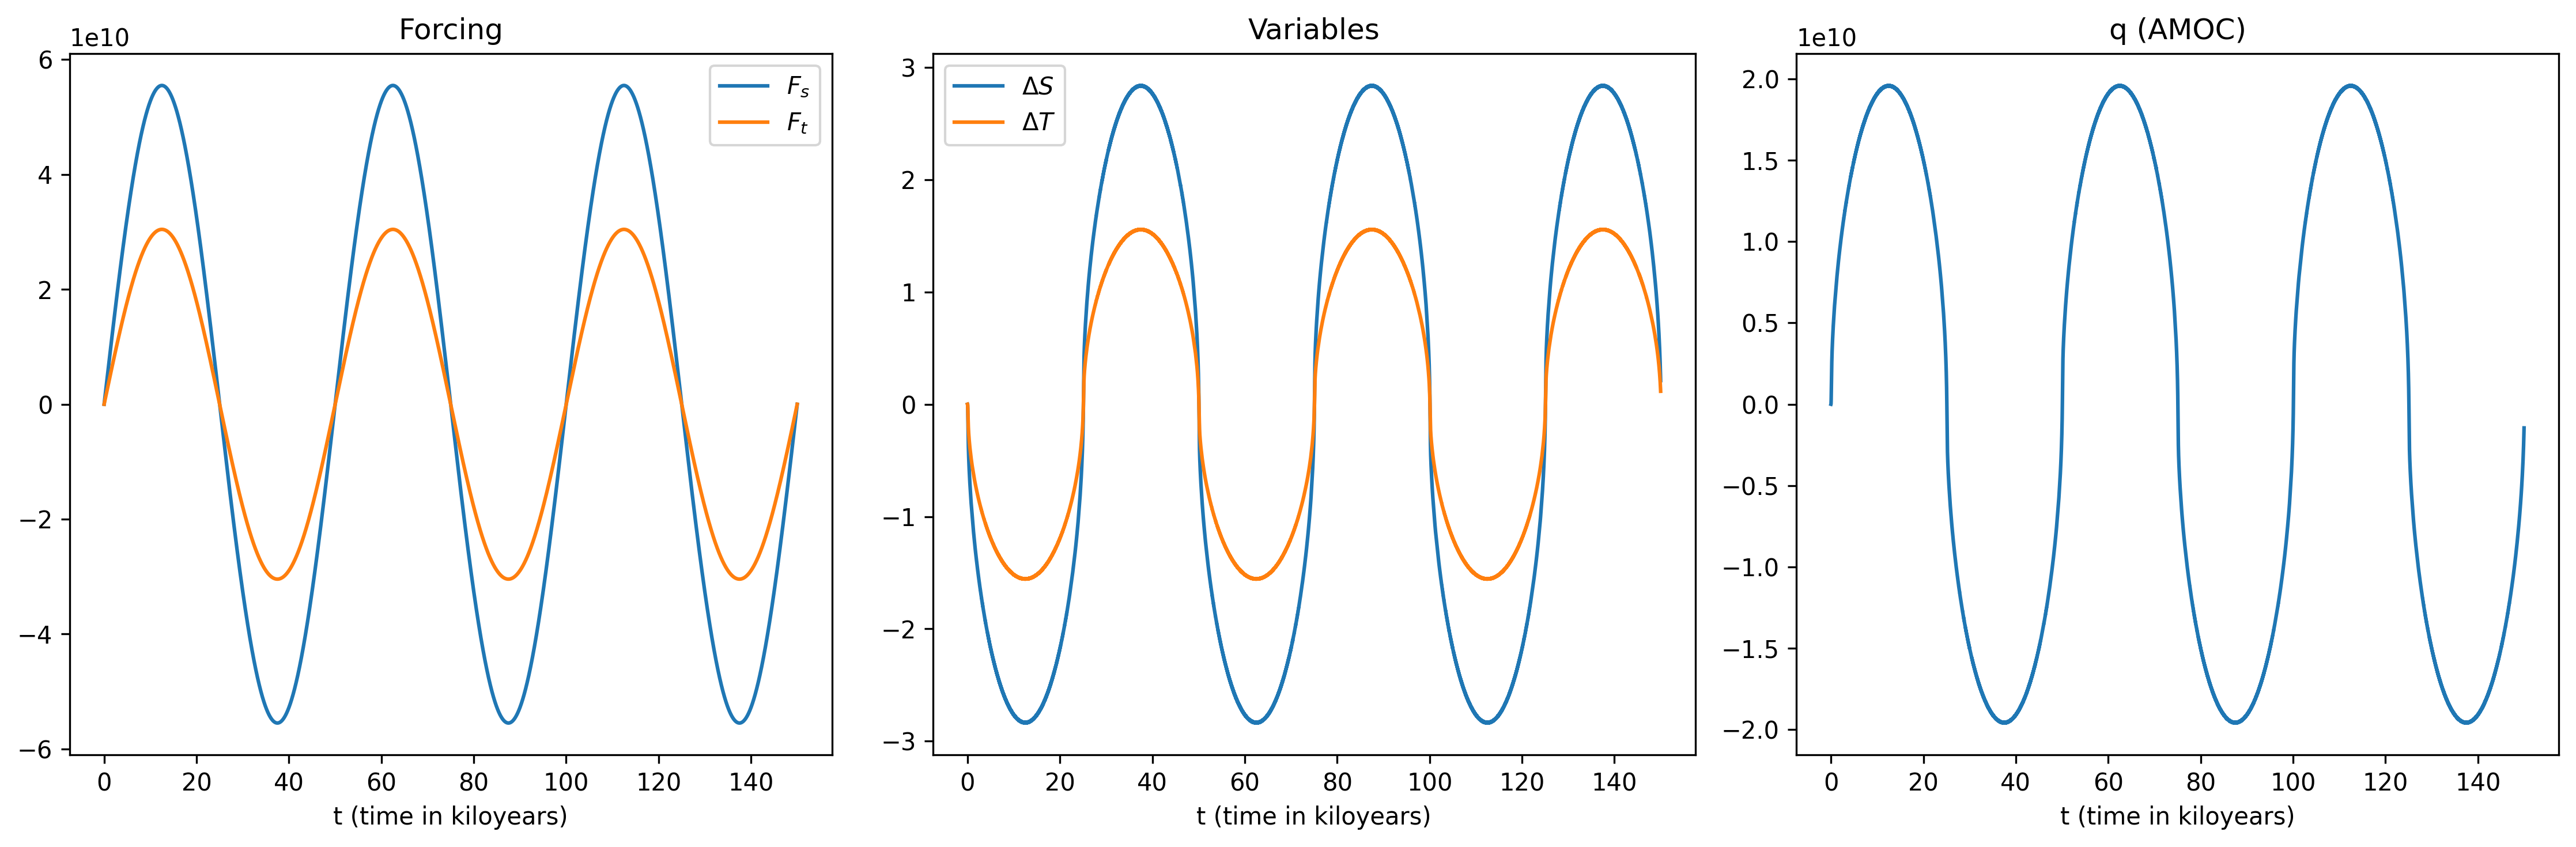

In [12]:
generate_plots("sine", True);

In [19]:
data = np.load('data_2e5/input_sal_temp_ns.npy');
time = data[:, 0]
salinity = data[:, 1]
temperature = data[:, 2]
fs = data[:, 3]
ft = data[:, 4]

In [20]:
time.shape

(200000,)

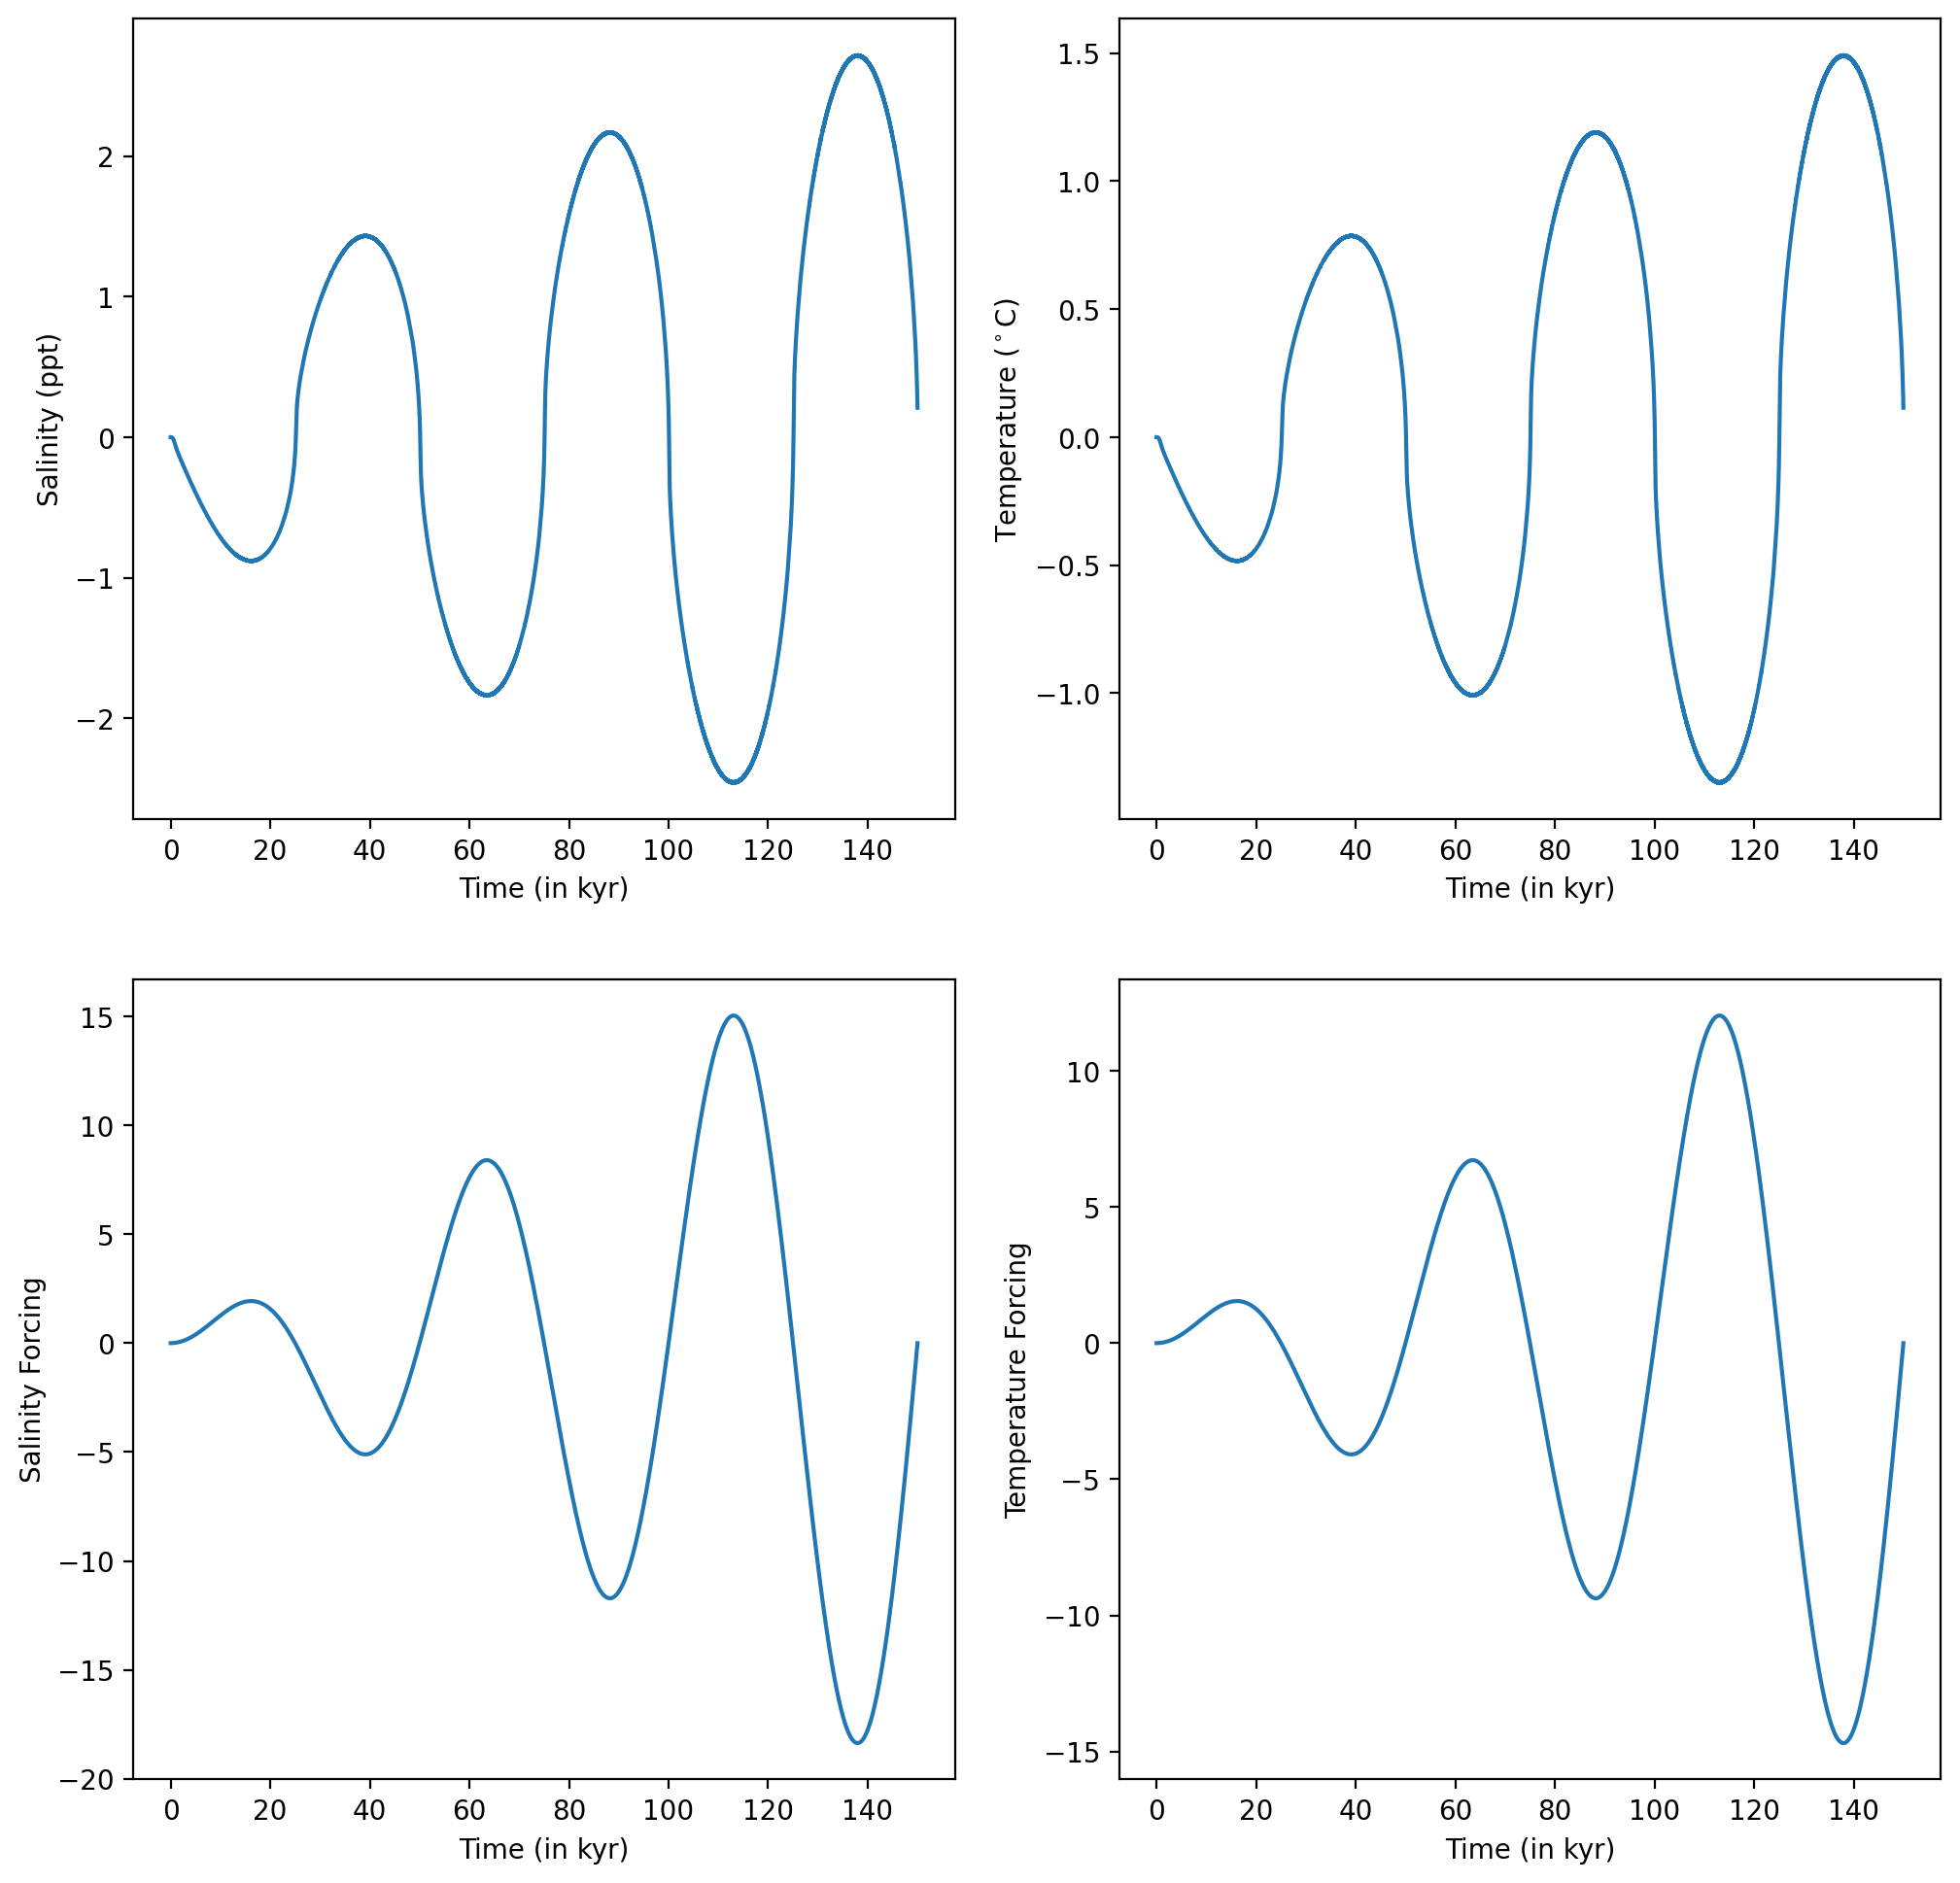

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=200);
ax[0, 0].plot(time, salinity);
ax[0, 0].set_xlabel('Time (in kyr)');
ax[0, 0].set_ylabel('Change in Salinity (ppt)')
ax[0, 1].plot(time, temperature);
ax[0, 1].set_ylabel('Change in Temperature ($^\circ$C)');
ax[0, 1].set_xlabel('Time (in kyr)');
ax[1, 0].set_ylabel('Salinity Forcing')
ax[1, 0].plot(time, fs/Fs_to_m_per_year);
ax[1, 0].set_xlabel('Time (in kyr)');
ax[1, 1].plot(time, ft/Ft_to_m_per_year);
ax[1, 1].set_xlabel('Time (in kyr)');
ax[1, 1].set_ylabel('Temperature Forcing');

In [20]:
q = np.load('data/q_sal_temp_ns.npy')

Text(0, 0.5, 'q (in Sv)')

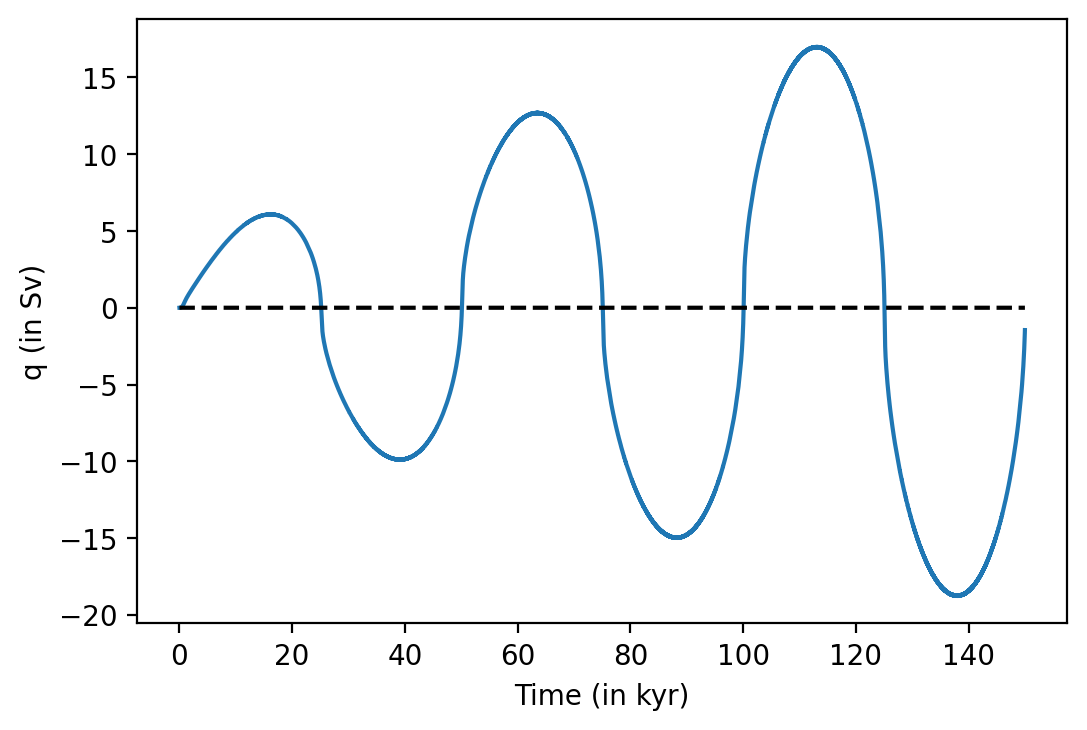

In [35]:
fig, ax = plt.subplots(dpi=200)
ax.plot(time, q/Sv)
ax.plot(time, time*0, 'k--')
ax.set_xlabel('Time (in kyr)')
ax.set_ylabel('q (in Sv)')

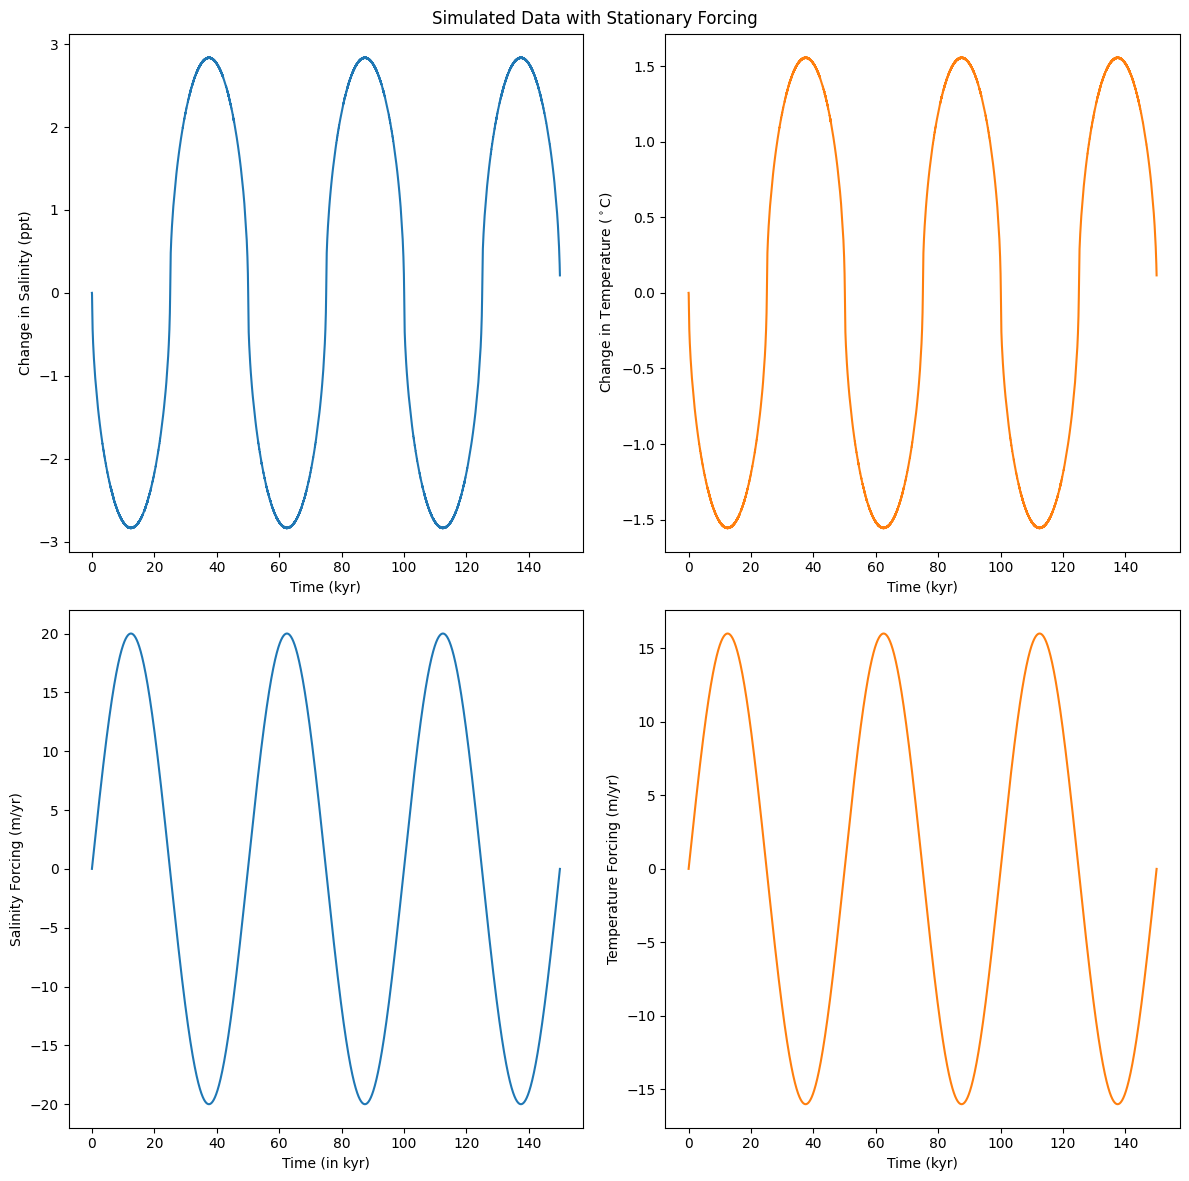

In [60]:
# generating stationary plots 
data_stationary = np.load('data/input_sal_temp_sine.npy')
time = data_stationary[:, 0]
salinity = data_stationary[:, 1]
temperature = data_stationary[:, 2]
fs = data_stationary[:, 3]
ft = data_stationary[:, 4]
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=100);
ax[0, 0].plot(time, salinity);
ax[0, 0].set_xlabel('Time (kyr)');
ax[0, 0].set_ylabel('Change in Salinity (ppt)')
ax[0, 1].plot(time, temperature, color='#ff7f0e');
ax[0, 1].set_ylabel('Change in Temperature ($^\circ$C)');
ax[0, 1].set_xlabel('Time (kyr)');
ax[1, 0].set_ylabel('Salinity Forcing (m/yr)')
ax[1, 0].plot(time, fs/Fs_to_m_per_year);
ax[1, 0].set_xlabel('Time (in kyr)');
ax[1, 1].plot(time, ft/Ft_to_m_per_year, color='#ff7f0e');
ax[1, 1].set_xlabel('Time (kyr)');
ax[1, 1].set_ylabel('Temperature Forcing (m/yr)');
fig.suptitle('Simulated Data with Stationary Forcing');
fig.tight_layout()
fig.savefig('figures/stationary_data');

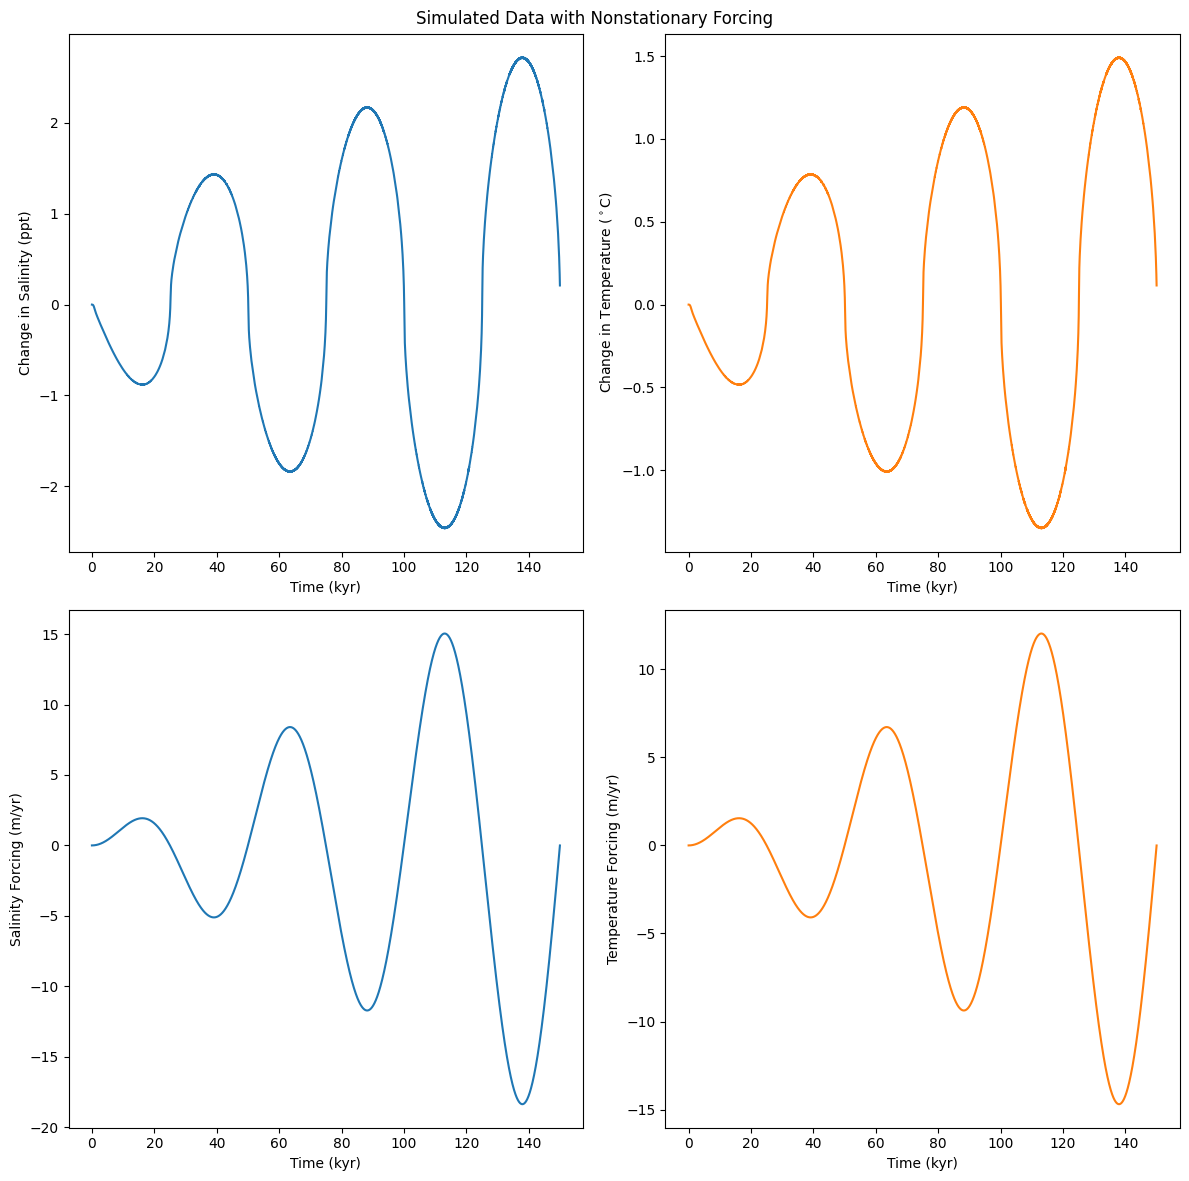

In [59]:
# generating nonstationary plots 
data_nonstationary = np.load('data/input_sal_temp_ns.npy')
time = data_stationary[:, 0]
salinity = data_nonstationary[:, 1]
temperature = data_nonstationary[:, 2]
fs = data_nonstationary[:, 3]
ft = data_nonstationary[:, 4]
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=100);
ax[0, 0].plot(time, salinity);
ax[0, 0].set_xlabel('Time (kyr)');
ax[0, 0].set_ylabel('Change in Salinity (ppt)')
ax[0, 1].plot(time, temperature, color='#ff7f0e');
ax[0, 1].set_ylabel('Change in Temperature ($^\circ$C)');
ax[0, 1].set_xlabel('Time (kyr)');
ax[1, 0].set_ylabel('Salinity Forcing (m/yr)')
ax[1, 0].plot(time, fs/Fs_to_m_per_year);
ax[1, 0].set_xlabel('Time (kyr)');
ax[1, 1].plot(time, ft/Ft_to_m_per_year, color='#ff7f0e');
ax[1, 1].set_xlabel('Time (kyr)');
ax[1, 1].set_ylabel('Temperature Forcing (m/yr)');
fig.suptitle('Simulated Data with Nonstationary Forcing');
fig.tight_layout()
fig.savefig('figures/nonstationary_data');

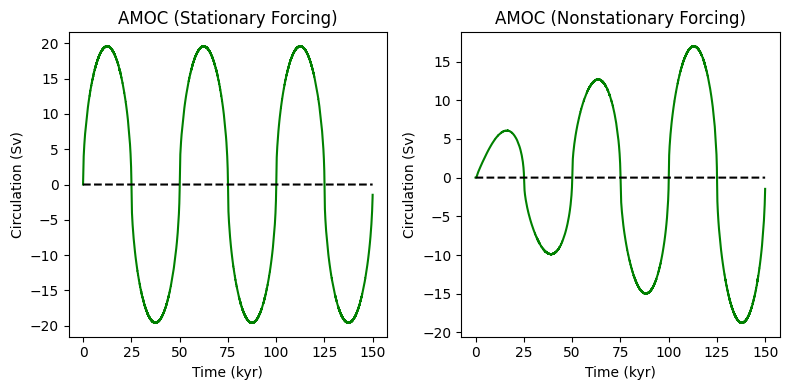

In [61]:
q_stationary = np.load('data/q_sal_temp_sine.npy')
q_nonstationary = np.load('data/q_sal_temp_ns.npy')
fig, ax = plt.subplots(1, 2, dpi=100, figsize=(8, 4))
ax[0].plot(time, q_stationary/Sv, color='green')
ax[0].plot(time, time*0, 'k--')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('Circulation (Sv)')
ax[1].plot(time, q_nonstationary/Sv, color='green')
ax[1].plot(time, time*0, 'k--')
ax[1].set_xlabel('Time (kyr)')
ax[1].set_ylabel('Circulation (Sv)')
ax[0].set_title('AMOC (Stationary Forcing)')
ax[1].set_title('AMOC (Nonstationary Forcing)')
fig.tight_layout()
fig.savefig('figures/amoc_scenarios')